# Prepare Renewable Potential

This tutorial contains various small guides for tasks you will need or come in handy in the upcoming group assignment.

We're going to need a couple of packages for this tutorial:

In [1]:
import atlite
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import Polygon, LineString, Point

import yaml
from yaml.loader import SafeLoader
from urllib.request import urlretrieve

## Downloading historical weather data from ERA5 with `atlite`

First, let's load some small example country. Let's say, the Netherlands.

In [3]:
regions = gpd.read_file("gadm_410-levels-ADM_1-PHL.gpkg")

<AxesSubplot:>

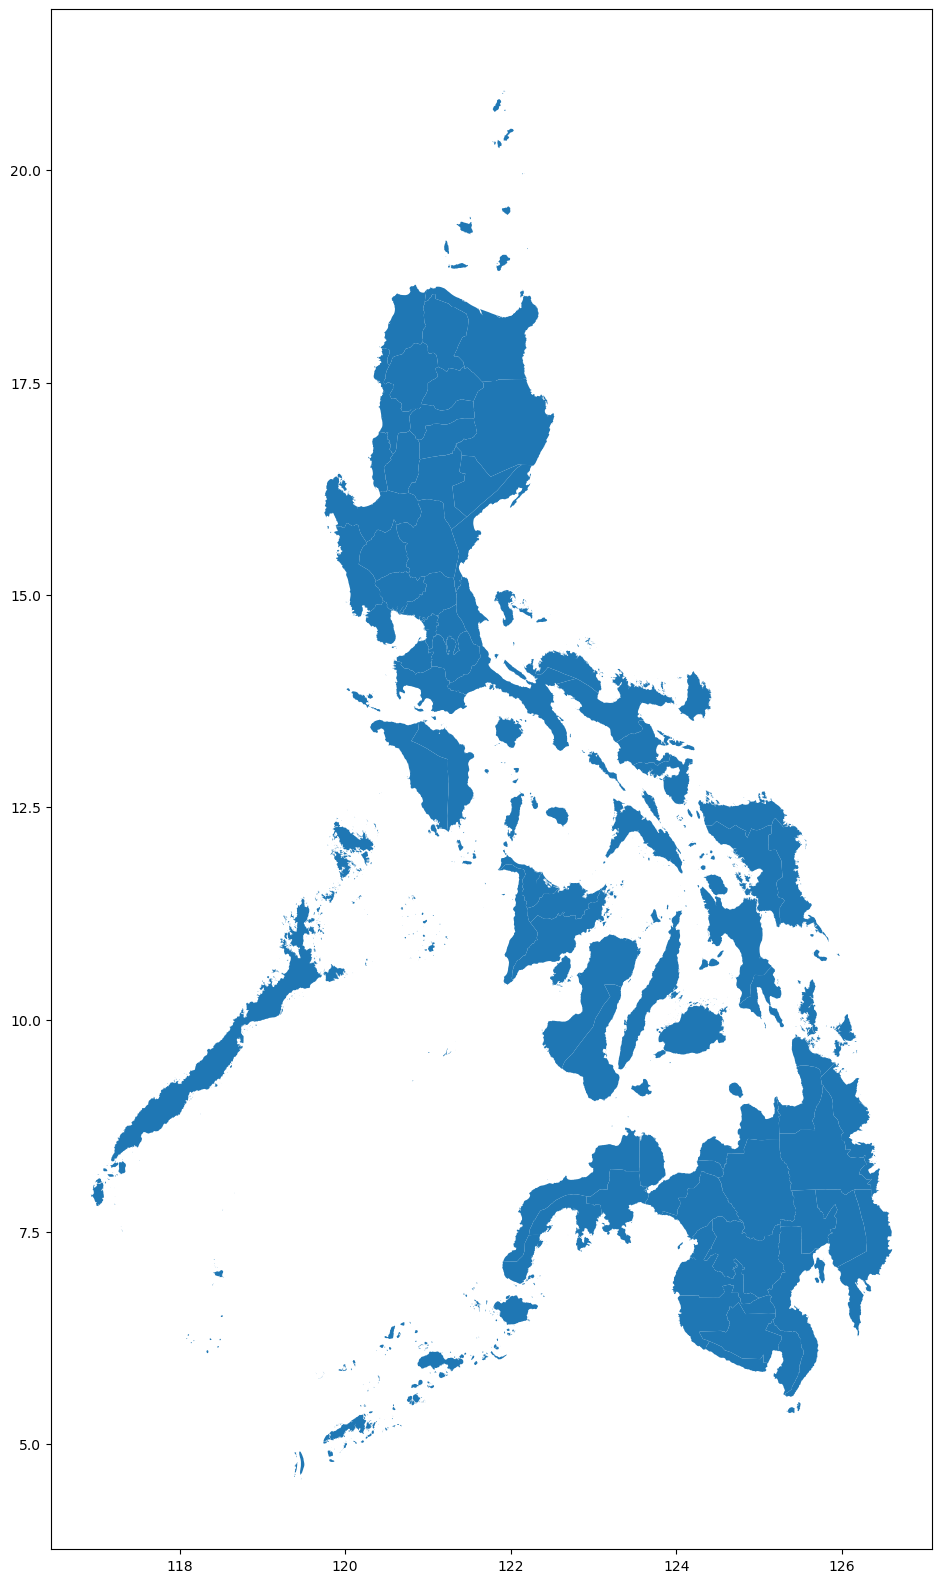

In [4]:
fig, ax = plt.subplots(figsize=(20,20))
regions.plot(ax=ax)

In this example we download historical weather data [ERA5 data](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) on-demand for a cutout we want to create.

:::{note}
For this example to work, you should have
- installed the Copernicus Climate Data Store `cdsapi` package (`conda list cdsapi` or `pip install cdsapi`) and
- registered and setup your CDS API key as described on [this website](https://cds.climate.copernicus.eu/api-how-to).
:::

A **cutout** is the basis for any of your work and calculations in `atlite`.

The cutout is created in the directory and file specified by the relative path. If a cutout at the given location already exists, then this command will simply load the cutout again. If the cutout does not yet exist, it will specify the new cutout to be created.

For creating the cutout, you need to specify the dataset (e.g. ERA5), a time period and the spatial extent (in latitude and longitude).

In [6]:
minx, miny, maxx, maxy = regions.total_bounds
buffer = 0.25

cutout = atlite.Cutout(
   path="PHL_atlite.nc",
   module="era5",
   x=slice(minx-buffer, maxx+buffer),
   y=slice(miny-buffer, maxy+buffer),
   time="2013",
)

#cutout.prepare()

Calling the function `cutout.prepare()` initiates the download and processing of the weather data.
Because the download needs to be provided by the CDS servers, this might take a while depending on the amount of data requested.

:::{note}
You can check the status of your request [here](https://cds.climate.copernicus.eu/cdsapp#!/yourrequests).
:::

In [ ]:
#url = "https://tubcloud.tu-berlin.de/s/5XE2FWCfkRc4kAm/download/PHL_atlite.nc"

#urlretrieve(url, "PHL_atlite.nc")

cutout = atlite.Cutout("PHL_atlite.nc") # if cutout not yet in computer

<GeoAxesSubplot:xlabel='x', ylabel='y'>

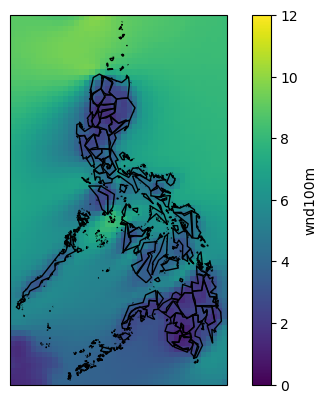

In [6]:
ax = plt.axes(projection=ccrs.PlateCarree())

cutout.data.wnd100m.mean(dim='time').plot(ax=ax, vmin=0, vmax=12)
regions.simplify(0.1).to_crs(4236).plot(ax=ax, edgecolor='k', color='none')

In [143]:
def extrapolate_wind_speed(hub_height):
    
    # v = v ref ln(z/z 0 )/ln(z ref /z 0 )
    wind_100 = cutout.data.wnd100m
    roughness = cutout.data.roughness
    wind_array = wind_100 * np.log(hub_height/roughness)/np.log(100/roughness)
    
    return wind_array

def region_wind(wind_array,region):
    cell_data=[]
    for x in np.arange(116.75,126.57,0.25):
        x = round(x,2)
        for y in np.arange(4.5,21.25,0.25):
            buffer = Point(x, y).buffer(0.25, cap_style = 3)
            if region.simplify(0.1).overlaps(buffer):
                x_cell = int((x - 116.8)*4)
                y_cell = int((y - 4.5)*4)
                cell_data= cell_data + [[y_cell,x_cell]]

    return sum(wind_array[:,y,x].to_pandas() for y,x in cell_data)/len(cell_data)
        
def wind_hist(df,name):
    plt.hist(x=df, bins=np.arange(-0.5,25.5,1), color='#0504aa', align='mid', alpha=0.7, rwidth=0.95)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('wind speed [m/s]')
    plt.ylabel('hours')
    plt.title(f'Wind Histogram of {name}')
    
def compile_hist():
    wind_array = extrapolate_wind_speed(100)
    df = pd.DataFrame()
    for i in regions.index:
        wind_series = region_wind(wind_array,regions.geometry[i])
        n, bins = np.histogram(wind_series, bins=np.arange(-0.5,25.5,1))
        df_new = pd.DataFrame(n.reshape(-1, len(n)), index = [regions.NAME_1[i]])
        df = pd.concat([df,df_new])
    
    df.to_csv('wind_histogram.csv')
    return df


In [144]:
#df_hist = compile_hist()

In [9]:
regions.NAME_1.tolist()

['Abra',
 'Agusan del Norte',
 'Agusan del Sur',
 'Aklan',
 'Albay',
 'Antique',
 'Apayao',
 'Aurora',
 'Basilan',
 'Bataan',
 'Batanes',
 'Batangas',
 'Benguet',
 'Biliran',
 'Bohol',
 'Bukidnon',
 'Bulacan',
 'Cagayan',
 'Camarines Norte',
 'Camarines Sur',
 'Camiguin',
 'Capiz',
 'Catanduanes',
 'Cavite',
 'Cebu',
 'Compostela Valley',
 'Davao del Norte',
 'Davao del Sur',
 'Davao Oriental',
 'Dinagat Islands',
 'Eastern Samar',
 'Guimaras',
 'Ifugao',
 'Ilocos Norte',
 'Ilocos Sur',
 'Iloilo',
 'Isabela',
 'Kalinga',
 'La Union',
 'Laguna',
 'Lanao del Norte',
 'Lanao del Sur',
 'Leyte',
 'Maguindanao',
 'Marinduque',
 'Masbate',
 'Metropolitan Manila',
 'Misamis Occidental',
 'Misamis Oriental',
 'Mountain Province',
 'Negros Occidental',
 'Negros Oriental',
 'North Cotabato',
 'Northern Samar',
 'Nueva Ecija',
 'Nueva Vizcaya',
 'Occidental Mindoro',
 'Oriental Mindoro',
 'Palawan',
 'Pampanga',
 'Pangasinan',
 'Quezon',
 'Quirino',
 'Rizal',
 'Romblon',
 'Samar',
 'Sarangani',
 

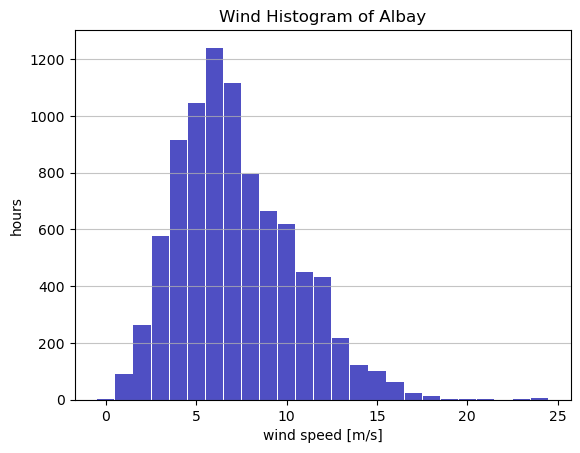

In [95]:
wind_array = extrapolate_wind_speed(100)
wind_series = region_wind(wind_array,regions.geometry[14])
wind_hist(wind_series,regions.NAME_1[14])

In [114]:
n, bins = np.histogram(wind_series, bins=np.arange(-0.5,25.5,1))
ans = pd.DataFrame(n.reshape(-1, len(n)), index = [regions.NAME_1[4]])
ans = pd.concat([ans,ans])

In [116]:
ans.to_csv('testing.csv')

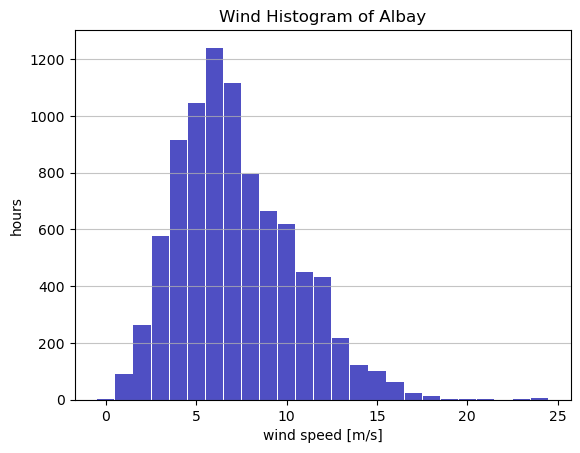

In [98]:
wind_hist(wind_series,regions.NAME_1[4])

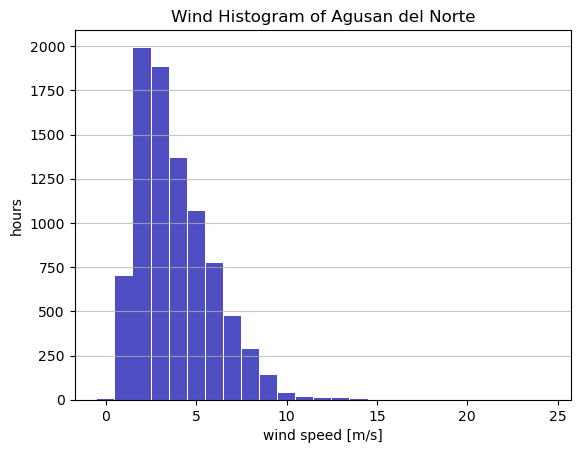

In [55]:
wind_series = region_wind(regions.geometry[1])
wind_hist(wind_series,regions.NAME_1[1])

<AxesSubplot:xlabel='time'>

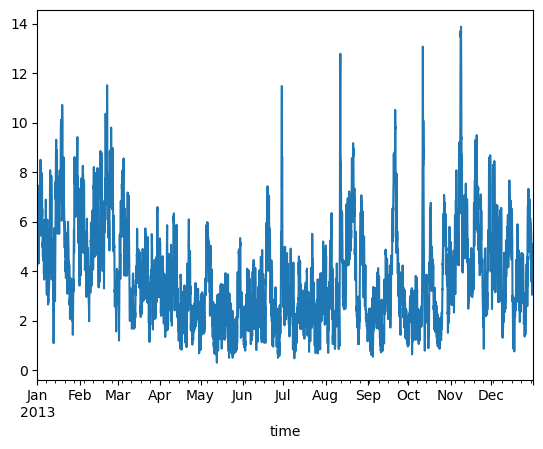

In [56]:
wind_series.plot()

In [43]:
# Open the file and load the file
turbine_typ = 'Vestas_V25_200kW'

url = f'https://raw.githubusercontent.com/PyPSA/atlite/master/atlite/resources/windturbine/{turbine_typ}.yaml'

urlretrieve(url,f'{turbine_typ}.yaml')

with open(f'{turbine_typ}.yaml','r') as f:
    data = yaml.load(f, Loader=SafeLoader)
    print(data)

{'name': 'Vestas V25 200 kW', 'manufacturer': 'Vestas', 'source': 'http://www.kulak.com.pl/Wiatraki/pdf/vestas%20v25.pdf', 'HUB_HEIGHT': 29, 'V': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 14, 25, 25], 'POW': [0, 0.0036, 0.0123, 0.0244, 0.0399, 0.0634, 0.0902, 0.1189, 0.1457, 0.1712, 0.1951, 0.2001, 0.2, 0.2, 0]}


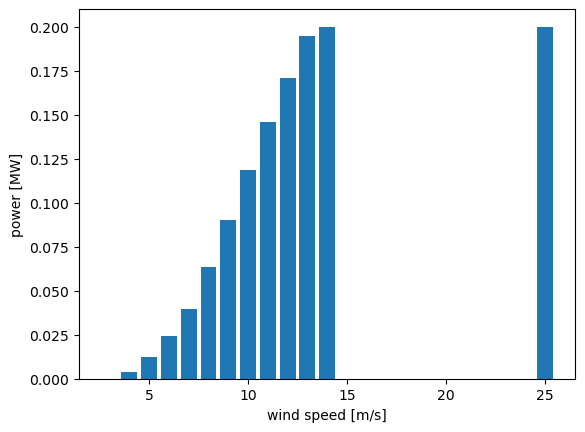

In [45]:
def leistung_hist(df):
    #for v in range(data['V'][0],data['V'][-1]):
        #if v not in data['V']:
        #    data['V'].insert(v,v)
        #    data['POW'].insert(v,data['POW'][v])
    
    plt.bar(df['V'],df['POW'])
    plt.xlabel('wind speed [m/s]')
    plt.ylabel('power [MW]')
    
leistung_hist(data)

In [ ]:
#https://gis.stackexchange.com/questions/314949/creating-square-buffers-around-points-using-shapely
#https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explode.html
# possible problem of multipolygon is because its multiple islands. need to explode it gdf_exploded=gdf.explode()
#https://stackoverflow.com/questions/65124253/polygon-object-is-not-iterable-ipython-cookbook

#matrix = cutout.indicatormatrix(regions)
#wind = cutout.data.wnd100m#.mean('time')
#matrix.dot(wind)
#matrix.T.dot(avg_wind)